In [1]:
%config IPCompleter.greedy=True

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [2]:
#test utils
import weapon_data as weapons

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded, _ = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
            
            
def get_weapon_data():
    return weapons.get_data(3, 12, 1)

In [6]:
import weapon_data as weapons

network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=16,
         n_hidden_2=15,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = lambda x : tf.nn.tanh(x)
num_epochs = 10
batch_size = 1
epoch_debug_step = 1
    
with tf.Session() as sess:
    train_data, test_data = get_weapon_data()
    network_architecture['n_input'] = train_data.num_features
  
    network = vae.get_new_trained(sess, train_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step)


Epoch:0001, cost=22.252041299

Epoch:0002, cost=20.215972078

Epoch:0003, cost=18.834537776

Epoch:0004, cost=18.258050686

Epoch:0005, cost=17.468047262

Epoch:0006, cost=17.479546855

Epoch:0007, cost=16.813450888

Epoch:0008, cost=15.878490309

Epoch:0009, cost=15.068870161

Epoch:0010, cost=15.495313536

Trained model saved! You can find it in './trained_vae/model.ckpt'



In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    train_data, test_data = get_weapon_data()
    samples = test_data.next_batch(1)
    x_reconstructed = network.encode_and_decode(samples)
    
    print(samples)
    print(x_reconstructed)
    
    
    
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,x_reconstructed), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[ 1.40150649  0.82948142  0.60118691  2.88712045  0.99569425 -1.04880885
   1.58113883 -0.48507125 -1.32959555  0.82220467 -0.26424317  0.4513875
  -0.57240795 -0.48010721 -0.97777561 -0.32444284 -0.32444284 -0.48507125
   1.78885438 -0.32444284 -0.40824829 -0.55901699]]
[[ 0.31589502  0.33757037  0.15587732  0.32921115  0.21974574 -0.91164726
   0.75485486  0.12902382 -0.61903006  0.12270112  0.31485996 -0.21458998
  -0.48973477 -0.13697842 -0.6768916   0.15905002  0.13858786  0.28317842
   0.3577404  -0.4882409   0.05679157 -0.5166566 ]]
damages_first = ['53.0', '43.32789065140148']
damages_last = ['38.0', '29.349479239220795']
dmg_distances_first = ['66.0', '22.108922666174994']
dmg_distances_last = ['89.0', '61.32283286865561']
firemode_Automatic = ['0.0', '0.06850299385887693']
firemode_Semi-Automatic = ['1.0', '0.626722950553579']
hiprecoildec = ['3.0', '4.406141366317528']
hiprecoilright = ['0.8999999761581421', '

In [12]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    _, test_data = get_weapon_data()
    num_samples = test_data.num_examples
    
    batch_size = 1
    avg_cost = 0.
    avg_distance_norm = 0
    avg_distance_unnorm = 0
    for i in range(num_samples):
        batch = test_data.next_batch(1)

        x_reconstructed = network.encode_and_decode(samples)
        cost = network.calculate_loss(batch)
        
        #print(batch[0])
        _, unstandardized_batch = test_data.decode_processed_tensor(batch[0])
        _, unstandardized_x = test_data.decode_processed_tensor(x_reconstructed[0])
        distance_unnorm = (sess.run(tf.reduce_sum(tf.abs(unstandardized_batch - unstandardized_x))))
        
        distance_norm = (sess.run(tf.reduce_sum(tf.abs(batch[0] - x_reconstructed[0]))))
        #print(cost)

        #compute average loss/cost
        avg_cost += cost / num_samples
        avg_distance_unnorm += distance_unnorm / num_samples
        avg_distance_norm += distance_norm / num_samples
    
    print("Average cost = " + "{:.9f}".format(avg_cost))
    print("Average unnormalized distance = " + "{:.9f}".format(avg_distance_unnorm))
    print("Average normalized distance = " + "{:.9f}".format(avg_distance_norm))


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Average cost = 16.150316011
Average unnormalized distance = 542.014407796
Average normalized distance = 18.915708601


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


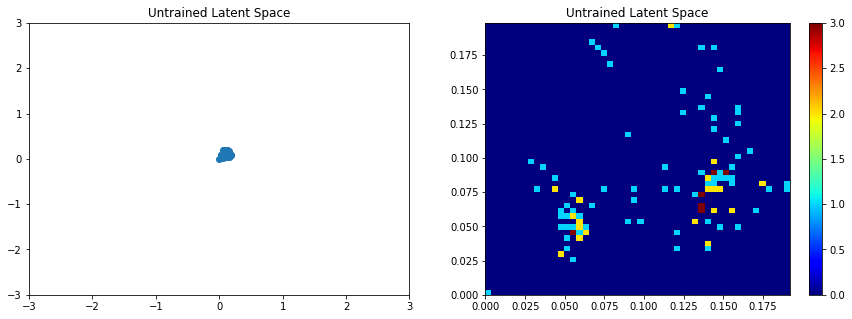

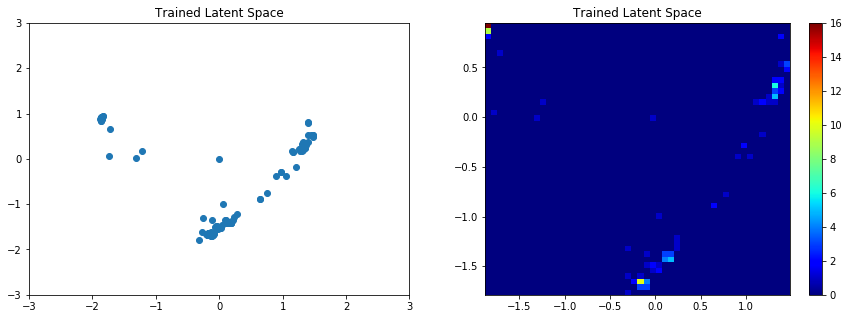

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((1,network_architecture['n_z']))
        
    train_data, test_data = get_weapon_data()
    total_batch = int(train_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = train_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space", z_mean=True)

In [13]:
# Testing
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []
    for i in range(4):
        random_val = np.random.normal(size=(1,network_architecture["n_z"]))
        x_test = network.decode_from_latent_space(random_val)
        generated.append(x_test[0])
        
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['81.14501802535267', '37.99001474982083', '65.1747215053313', '35.101802970275884']
damages_last = ['70.30277731443357', '21.181006150942153', '50.42946764922374', '20.149030829844513']
dmg_distances_first = ['7.719734568221325', '21.370772431492668', '15.429994241057024', '19.038814236996863']
dmg_distances_last = ['126.23351829435981', '46.830762106330866', '94.81158173285408', '43.3506464367037']
firemode_Automatic = ['0.017815899766150056', '0.28248220211565267', '-0.045153416195217067', '0.5287769528679183']
firemode_Semi-Automatic = ['0.12918095443665722', '0.6435731722501039', '0.5078695703868116', '0.4287639680955724']
hiprecoildec = ['3.2300378432355346', '5.701299905185159', '3.5155589980041144', '6.755830501181775']
hiprecoilright = ['0.9064637588041147', '0.44461377610911323', '0.7435536418092499', '0.3874253723452334']
hiprecoilup = ['5.236704622784657', '1.9263852653213749', '4.2418813483480